In [11]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord

# utils
import sys
sys.path.append('../utils')
from utils import partial_corr, compute_tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate graph and data (Hub-network)

In [2]:
# we use pre-made hub-network graph structure, which was constructed by the following procedure:
# (1) create a Barabasi-Albert scale-free graph
# (2) randomly choose 5% of the nodes to be hub nodes
# (3) for each hub node, construct a complete sub-graph (clique)
Skel = np.genfromtxt('../data/hub-network-structure.txt', delimiter=',')

n, p = 500, 1000
n_prop_to_p = [0.5]
random_state = 2023
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]

# projection method
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Theta = np.multiply(edge_weights, edge_signs)
Theta = np.multiply(Skel, Theta)
Theta = np.tril(Theta) + np.tril(Theta).T
nz_indx = np.nonzero(Theta)
for i in range(100):
    Theta = proj_precision_mat(Theta, nz_indx)
    if np.linalg.cond(Theta) < 20:
        break

Theta = np.real(Theta)
Partial_corr = partial_corr(Theta)
Sigma = np.linalg.inv(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Generate graph and data (Erdos-Renyi)

In [2]:
n, p = 500, 1000
n_prop_to_p = [0.5]
Theta, Sigma = generate_erdos_renyi(p, n_prop_to_p, type='proj', edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2023)
Partial_corr = partial_corr(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Select the best $\lambda$ based on pseudo-BIC

In [3]:
S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)

pseudo_bics = []
precs, recalls, mccs = [], [], []

# lams = lams[::-1][14:26] # pre-selected lambdas for hub-network
lams = lams[::-1][7:19] # pre-selected lambdas for erdos-renyi
for lam in lams:
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
    pseudo_bic = pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2)
    pseudo_bics.append(pseudo_bic)
    tp, fp = compute_tp_fp(Theta, Theta_hat)
    prec, recall = precision_recall(Theta, Theta_hat)
    precs.append(prec)
    recalls.append(recall)
    mccs.append(mcc(Theta, Theta_hat))
    print('lam:', np.round(lam, 4), ', # of nonzero:', len(np.flatnonzero(Theta_hat)), ', TP:', tp, ', FP:', fp,\
           ', MCC:', np.round(mcc(Theta, Theta_hat),3),\
           'Precision:', np.round(prec,3),\
           'Recall:', np.round(recall,3),\
           ', Pseudo BIC:', pseudo_bic)
    
best_lam = lams[np.argmin(pseudo_bics)]

lam: 0.2121 , # of nonzero: 2924 , TP: 1924 , FP: 0 , MCC: 0.441 Precision: 1.0 Recall: 0.196 , Pseudo BIC: 507086.0567886109
lam: 0.1959 , # of nonzero: 3988 , TP: 2986 , FP: 2 , MCC: 0.55 Precision: 0.999 Recall: 0.305 , Pseudo BIC: 502383.6390114317
lam: 0.1809 , # of nonzero: 4980 , TP: 3974 , FP: 6 , MCC: 0.635 Precision: 0.998 Recall: 0.406 , Pseudo BIC: 495695.2905036161
lam: 0.1671 , # of nonzero: 6058 , TP: 4996 , FP: 62 , MCC: 0.708 Precision: 0.988 Recall: 0.51 , Pseudo BIC: 488735.02949760447
lam: 0.1544 , # of nonzero: 7136 , TP: 5908 , FP: 228 , MCC: 0.76 Precision: 0.963 Recall: 0.603 , Pseudo BIC: 481546.70881692093
lam: 0.1426 , # of nonzero: 8438 , TP: 6700 , FP: 738 , MCC: 0.783 Precision: 0.901 Recall: 0.684 , Pseudo BIC: 475748.93698913825
lam: 0.1317 , # of nonzero: 10210 , TP: 7408 , FP: 1802 , MCC: 0.778 Precision: 0.804 Recall: 0.756 , Pseudo BIC: 472781.6866872934
lam: 0.1216 , # of nonzero: 13046 , TP: 7928 , FP: 4118 , MCC: 0.727 Precision: 0.658 Recall: 0.8

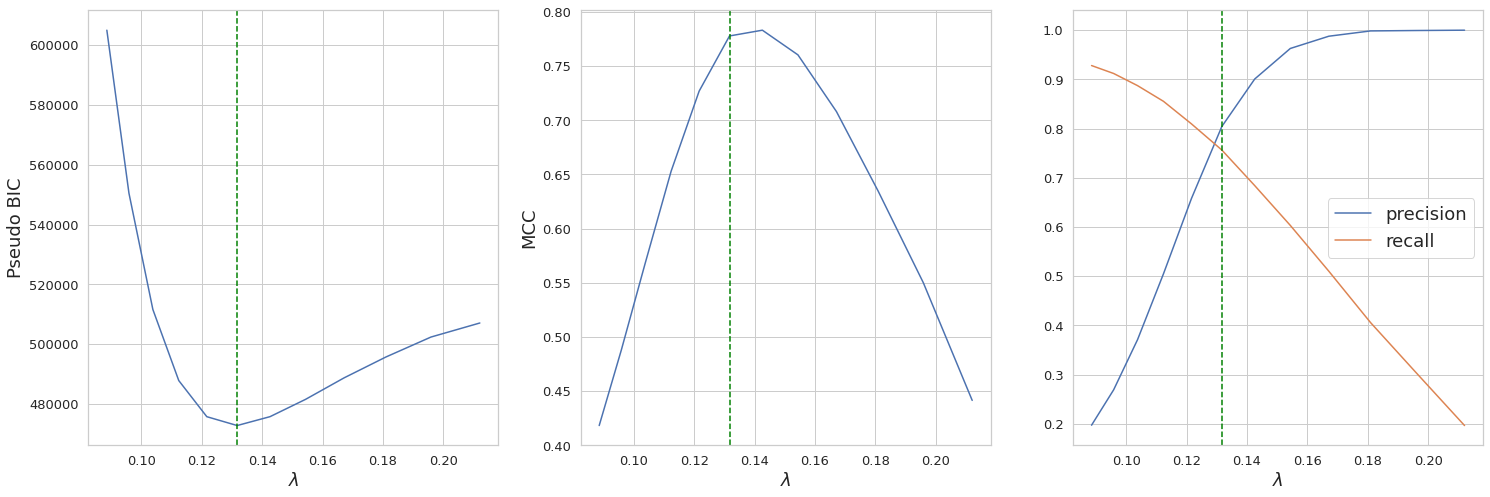

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
axes = axes.ravel()

i = 0
axes[i].plot(lams, pseudo_bics)
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].set_ylabel('Pseudo BIC', fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13)

i = 1
axes[i].plot(lams, mccs)
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].set_ylabel('MCC', fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13)

i = 2
axes[i].plot(lams, precs, label='precision')
axes[i].plot(lams, recalls, label='recall')
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].legend(fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13);

### Refit ACCORD for debiasing

In [5]:
# fit with best lam
model = GraphicalAccord(Omega_star=np.eye(p), lam1=best_lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
model.fit(X)
Omega_hat = model.omega_.toarray()
Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
Partial_corr_hat = partial_corr(Theta_hat)

# refit for debiasing
lam_mat = np.where(Theta_hat != 0, 0, 1000.0)
model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam_mat, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
model.fit(X)
Omega_hat_debiased = model.omega_.toarray()
Theta_hat_debiased = 0.5 * ((np.diag(np.diag(Omega_hat_debiased)) @ Omega_hat_debiased) + (Omega_hat_debiased.T @ np.diag(np.diag(Omega_hat_debiased))))
Partial_corr_hat_debiased = partial_corr(Theta_hat_debiased)

### Summarize results

In [6]:
# set diagnoals to zero
np.fill_diagonal(Partial_corr, 0)
np.fill_diagonal(Partial_corr_hat, 0)
np.fill_diagonal(Partial_corr_hat_debiased, 0)

# get TP/FP indices
TP_indx_biased = np.intersect1d(np.flatnonzero(Partial_corr), np.flatnonzero(Partial_corr_hat))
FP_indx_biased = np.setdiff1d(np.flatnonzero(Partial_corr_hat), np.flatnonzero(Partial_corr))
FN_indx_biased = np.intersect1d(np.flatnonzero(Partial_corr), np.where(Partial_corr_hat.ravel() == 0)[0])
TN_indx_biased = np.intersect1d(np.where(Partial_corr.ravel() == 0)[0], np.where(Partial_corr_hat.ravel() == 0)[0])

TP_indx_debiased = np.intersect1d(np.flatnonzero(Partial_corr), np.flatnonzero(Partial_corr_hat_debiased))
FP_indx_debiased = np.setdiff1d(np.flatnonzero(Partial_corr_hat_debiased), np.flatnonzero(Partial_corr))
FN_indx_debiased = np.intersect1d(np.flatnonzero(Partial_corr), np.where(Partial_corr_hat_debiased.ravel() == 0)[0])
TN_indx_debiased = np.intersect1d(np.where(Partial_corr.ravel() == 0)[0], np.where(Partial_corr_hat_debiased.ravel() == 0)[0])

In [7]:
print(' - Biased Metrics')
print('Fro. Norm squared of TPs:', np.linalg.norm(Partial_corr.ravel()[TP_indx_biased] - Partial_corr_hat.ravel()[TP_indx_biased])**2)
print('Fro. Norm squared of FPs:', np.linalg.norm(Partial_corr.ravel()[FP_indx_biased] - Partial_corr_hat.ravel()[FP_indx_biased])**2)
print('Fro. Norm squared of total:', np.linalg.norm(Partial_corr - Partial_corr_hat)**2)
print(' ')
print('Average Fro. Norm squared of TPs:', (np.linalg.norm(Partial_corr.ravel()[TP_indx_biased] - Partial_corr_hat.ravel()[TP_indx_biased])**2)/len(TP_indx_biased))
print('Average Fro. Norm squared of FPs:', (np.linalg.norm(Partial_corr.ravel()[FP_indx_biased] - Partial_corr_hat.ravel()[FP_indx_biased])**2)/len(FP_indx_biased))
print('\n')

print(' - Debiased Metrics')
print('Fro. Norm squared of TPs:', np.linalg.norm(Partial_corr.ravel()[TP_indx_debiased] - Partial_corr_hat_debiased.ravel()[TP_indx_debiased])**2)
print('Fro. Norm squared of FPs:', np.linalg.norm(Partial_corr.ravel()[FP_indx_debiased] - Partial_corr_hat_debiased.ravel()[FP_indx_debiased])**2)
print('Fro. Norm squared of total:', np.linalg.norm(Partial_corr - Partial_corr_hat_debiased)**2)
print(' ')
print('Average Fro. Norm squared of TPs:', (np.linalg.norm(Partial_corr.ravel()[TP_indx_debiased] - Partial_corr_hat_debiased.ravel()[TP_indx_debiased])**2)/len(TP_indx_debiased))
print('Average Fro. Norm squared of FPs:', (np.linalg.norm(Partial_corr.ravel()[FP_indx_debiased] - Partial_corr_hat_debiased.ravel()[FP_indx_debiased])**2)/len(FP_indx_debiased))

 - Biased Metrics
Fro. Norm squared of TPs: 73.27114761178916
Fro. Norm squared of FPs: 0.2533588013691982
Fro. Norm squared of total: 103.96710526093935
 
Average Fro. Norm squared of TPs: 0.009890813662498537
Average Fro. Norm squared of FPs: 0.0001405986689063253


 - Debiased Metrics
Fro. Norm squared of TPs: 8.205098022151764
Fro. Norm squared of FPs: 22.75020425272301
Fro. Norm squared of total: 61.39790112265573
 
Average Fro. Norm squared of TPs: 0.0011075996250204867
Average Fro. Norm squared of FPs: 0.012624974613053834


In [8]:
# get partial correlations for TP/FP
true_nonzeros = Partial_corr[Partial_corr != 0]

biased_nonzeros_TP = Partial_corr_hat.ravel()[TP_indx_biased]
biased_nonzeros_FP = Partial_corr_hat.ravel()[FP_indx_biased]

debiased_nonzeros_TP = Partial_corr_hat_debiased.ravel()[TP_indx_debiased]
debiased_nonzeros_FP = Partial_corr_hat_debiased.ravel()[FP_indx_debiased]

### Visualization (hub-network)

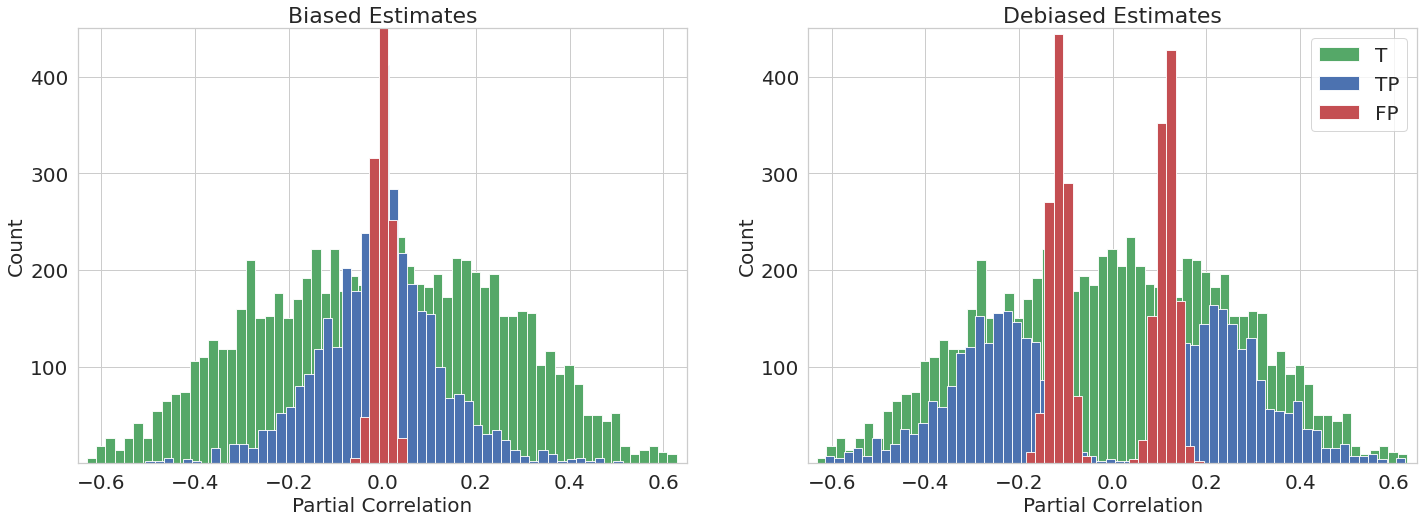

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes = axes.ravel()
binwidth=0.02

i = 0
sns.histplot(true_nonzeros, color=sns.color_palette()[2], binwidth=binwidth, alpha=1, label='T', ax=axes[i])
sns.histplot(biased_nonzeros_TP, color=sns.color_palette()[0], binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(biased_nonzeros_FP, color=sns.color_palette()[3], binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_yticks([100, 200, 300, 400])
axes[i].set_title('Biased Estimates', fontsize=22)
axes[i].set_xlabel('Partial Correlation', fontsize=20)
axes[i].set_ylabel('Count', fontsize=20)
axes[i].set_xlim((-0.65,0.65))
axes[i].set_ylim((0,450))

i = 1
sns.histplot(true_nonzeros, color=sns.color_palette()[2], binwidth=binwidth, alpha=1, label='T', ax=axes[i])
sns.histplot(debiased_nonzeros_TP, color=sns.color_palette()[0], binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(debiased_nonzeros_FP, color=sns.color_palette()[3], binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_yticks([100, 200, 300, 400])
axes[i].set_title('Debiased Estimates', fontsize=22)
axes[i].set_xlabel('Partial Correlation', fontsize=20)
axes[i].set_ylabel('Count', fontsize=20)
axes[i].set_xlim((-0.65,0.65))
axes[i].set_ylim((0,450))
axes[i].legend(fontsize=20)

plt.savefig('../output/debiasing-hub-network.png', bbox_inches='tight');

### Visualization (Erdos-Renyi)

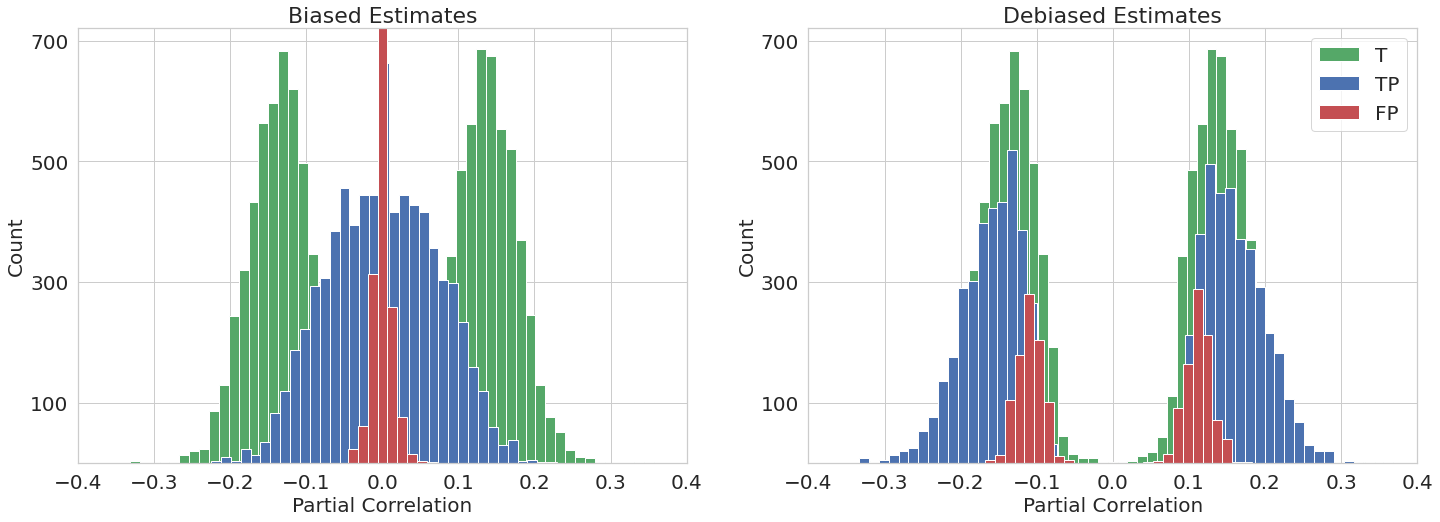

In [12]:
# erdos-renyi
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes = axes.ravel()
binwidth=0.013

i = 0
sns.histplot(true_nonzeros, color=sns.color_palette()[2], binwidth=binwidth, alpha=1, label='T', ax=axes[i])
sns.histplot(biased_nonzeros_TP, color=sns.color_palette()[0], binwidth=binwidth,  alpha=1, label='TP', ax=axes[i])
sns.histplot(biased_nonzeros_FP, color=sns.color_palette()[3], binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_yticks([100, 300, 500, 700])
axes[i].set_title('Biased Estimates', fontsize=22)
axes[i].set_xlabel('Partial Correlation', fontsize=20)
axes[i].set_ylabel('Count', fontsize=20)
axes[i].set_xlim((-0.4,0.4))
axes[i].set_ylim((0,720))

i = 1
sns.histplot(true_nonzeros, color=sns.color_palette()[2], binwidth=binwidth, alpha=1, label='T', ax=axes[i])
sns.histplot(debiased_nonzeros_TP, color=sns.color_palette()[0], binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(debiased_nonzeros_FP, color=sns.color_palette()[3], binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_yticks([100, 300, 500, 700])
axes[i].set_title('Debiased Estimates', fontsize=22)
axes[i].set_xlabel('Partial Correlation', fontsize=20)
axes[i].set_ylabel('Count', fontsize=20)
axes[i].set_xlim((-0.4,0.4))
axes[i].set_ylim((0,720))
axes[i].legend(fontsize=20);

plt.savefig('../output/debiasing-erdos-renyi.png', bbox_inches='tight');